# <center> Camera calibration via PGO</center>

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch

from cam import *
from pgo import *
from plot import *
from utils import *
%matplotlib widget

# 1. Calibrate cube
## 1.1 Parameters
Edit calibration data and parameters in the next cell.

In [2]:
# This is a file created by blender via render.py
# It stores the actual cameras used already in OpenCV format
cams_path = "./render/cameras.json"
cams = load_cameras(cams_path)

cams
# Edit OpenCV marker IDs here. Should be a list of strings.
# Check which IDs were used in ./cube_creator.py
marker_ids = list(map(str, range(24)))

# Edit path to the folder containing the cube images.
cube_im_folder = "./cube_calib_im/"

# Edit marker size (in meters)
# Check ./render.py to be sure
marker_size = 0.47 * 0.575

# Edit noise model here
k_r = lambda t : 0.5 * np.exp( -1.0 * np.linalg.norm(t, ord=2) )
k_t = lambda t : 1.0 * np.exp( 2.5 * np.linalg.norm(t, ord=2) )

## 1.2 Detect markers, compute pose through P4P and run PGO to estimate marker poses within the cube
Do not change next cell.

In [3]:
im_data = {}
im_data['filenames'] = [os.path.join(cube_im_folder, f, s) for f in os.listdir(cube_im_folder) \
                        for s in os.listdir(os.path.join(cube_im_folder,f)) if s.endswith(".jpg")]

# These are the params used for camera 471 when the cube was calibrated
f  = 29 / 36 * 1280
cx = 1280 * 0.5
cy = 720 * 0.5 

im_data['cams'] = [Camera(id=i,
                          intrinsics=np.array([[f,0,cx],[0,f,cy],[0,0,1]]),
                          distortion=cams['471'].distortion, 
                          extrinsics=cams['471'].extrinsics) for i in os.listdir(cube_im_folder)]

aux = estimate_pose_mp(cams=im_data['cams'],
                       im_filenames=im_data['filenames'],
                       aruco='DICT_4X4_1000',
                       marker_size=marker_size,
                       corner_refine='CORNER_REFINE_APRILTAG',
                       marker_ids=marker_ids)

aux = {k:v for k,v in aux.items() if v['reprojected_err'] < 0.1}

cam_cube_edges = {}
for k, v in aux.items():
    v['k_r'] = k_r(v['pose'].t())
    v['k_t'] = k_t(v['pose'].t())
    cam_cube_edges['c' + k[0], k[1].split('_')[-1]] = v

pgo = PGO(edges=cam_cube_edges, dtype=np.float32)
cube_pose_est = pgo.optimize()
cube_pose_est = {k : v for k,v in cube_pose_est.items() if k[0][0] != 'c'}


Marker detection
Received 777 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 777 images
Finished: 6234 markers detected.

----------------* PGO *----------------
Received 5390 edges.
Total of 799 nodes.
Final graph is connected.
	799 nodes
	5390 edges
Building SO(3) sparse block-matrix...


  0%|          | 0/5390 [00:00<?, ?it/s]

	SO(3) Eigenvalues: [2.6159869e-06 2.8812651e-06 3.4972459e-06 5.3388748e-02 5.3388748e-02]
	SO(3) Eigengap:    1.527e+04
Building SO(3) sparse block-matrix...


  0%|          | 0/5390 [00:00<?, ?it/s]

Done!


# 2. Camera calibration
## 2.1 Parameters

In [4]:
im_path = "./render/"

im_data = {"filename"  : [],
           "timestamp" : [],
           "cam"       : [],
           "cam_id"    : []}

timestamps = [t for t in os.listdir(im_path) if t.isnumeric() and os.path.isdir(os.path.join(im_path, t))]
for t in timestamps:
    filenames = os.listdir(os.path.join(im_path, t))
    for filename in filenames:
        if filename.endswith('.jpg'):
            cam_id = filename.split('.')[0]
            im_data['cam_id'].append(cam_id)
            im_data['filename'].append(os.path.join(im_path, t, filename))
            im_data['timestamp'].append(t)
            im_data['cam'].append(cams[cam_id])

## 2.2 Detect markers, estimate camera-marker pose through P4P
**cam_marker_edges** is a dictionary where each key is a tuple (node,node) and the value is a dictionary with keys _'pose'_, _'corners'_, _'reprojected_err'_, _'im_filename'_. Alternatively load a previous file to avoid computations.

In [5]:
cam_marker_edges = estimate_pose_mp(cams=im_data['cam'],
                                    im_filenames=im_data['filename'],
                                    aruco='DICT_4X4_1000',
                                    marker_size=marker_size,
                                    corner_refine='CORNER_REFINE_APRILTAG',
                                    marker_ids=marker_ids)

torch.save(cam_marker_edges, './cam_marker_edges.pt')
#cam_marker_edges = torch.load('./cam_marker_edges.pt')


Marker detection
Received 93120 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 77014 images
Finished: 452884 markers detected.


## 2.3 Optimization
We don't use vanilla PGO here because there are too many edges & nodes.
**Takeways**: When the number of cube positions is small there is little advantage of running **Ravess** with more than 1 iteration. When the problem takes on a massive size (input graph with more than $10^5$ edges), using 2 iterations can bring about a dramatic drop in error (1 iteration corresponds to simply computing and projecting eigenvectors to SO(3)). Check the eigengap. It should be larger than $10^4$. If not increase the **maxiter**. When the graph is small setting a **reprojection error threshold** too low will likely lead to disconnected graphs. For big problems it is necessary to set it as low as possible to ensure good results. Note that this threshold may change from problem to problem as it depends on the image quality. The current renders support reprojection error thresholds as low as $0.07$. Usually as we decrease the reprojection error threshold, the coefficients in the noise models should also approach 0.

In [6]:
pose_est = bipartite_se3sync(cam_marker_edges,
                             constraints=cube_pose_est,
                             noise_model_r=lambda pose : np.exp(-1.0 * np.linalg.norm(pose.t(), ord=2)),
                             noise_model_t=lambda pose : np.exp(-0.01 * np.linalg.norm(pose.t(), ord=2)),
                             edge_filter=lambda edge : edge['reprojected_err'] < 0.08,
                             maxiter=2,
                             dtype=np.float32)

Received graph with 85062 nodes 452884 edges
Applying constraints...


  0%|          | 0/452884 [00:00<?, ?it/s]

New SO(3) graph contains 5270 nodes 72395 edges
Building sparse adjacency and SO(3) connection Laplacian...


  0%|          | 0/72395 [00:00<?, ?it/s]

Iter 0
	Computing eigenvalues...
	SO(3) Eigenvalues: [5.8308444e-05 5.6083678e-05 5.5262950e-05 2.1370195e-03 2.1370167e-03]
	SO(3) Eigengap:    3.867e+01
Iter 1
	Computing eigenvalues...
	SO(3) Eigenvalues: [ 5.34703032e-08  6.11614105e-09 -1.27401748e-08  2.13700716e-03
  2.13700731e-03]
	SO(3) Eigengap:    1.677e+05
Building sparse 939024x15810 incidence matrix...


  0%|          | 0/313008 [00:00<?, ?it/s]

Solving sparse linear system...
Done!


## 2.4 Numeric results: comparison with ground-truth

In [7]:
missing_cam_ids = [c for c in cams.keys() if c not in pose_est.keys()]
valid_cam_ids   = [c for c in cams.keys() if c in pose_est.keys()]

G = optimize_gauge_se3([cams[n].extrinsics.inv() for n in valid_cam_ids],
                       [pose_est[n] for n in valid_cam_ids])
r_err  = []
t_err  = []
for n in valid_cam_ids:
    gt  = cams[n].extrinsics.inv()
    est = pose_est[n] @ G
    t_err.append(np.linalg.norm(gt.t() - est.t(), ord=2)*100)
    r_err.append(so3_distance(gt.R(), est.R()))              

print("SO(3)\t min: {:.3f}deg  |  avg: {:.3f}deg  |  median: {:.3f}deg  |  max: {:.3f}deg".format(np.min(r_err), np.mean(r_err), np.median(r_err), np.max(r_err)))
print("E(3) \t min: {:.3f}cm   |  avg: {:.3f}cm   |  median: {:.3f}cm   |  max: {:.3f}cm".format(np.min(t_err), np.mean(t_err), np.median(t_err), np.max(t_err)))
print("Missing cam IDs: {}".format(missing_cam_ids))

SO(3)	 min: 0.000deg  |  avg: 0.062deg  |  median: 0.056deg  |  max: 0.190deg
E(3) 	 min: 0.459cm   |  avg: 2.926cm   |  median: 2.536cm   |  max: 8.806cm
Missing cam IDs: []


In [8]:
%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(r_err, 'o')
plt.title("Absolute SO(3) errors ({} cameras)".format(len(cams)))
plt.xlabel("Camera id")
plt.ylabel("SO(3) distance wrt GT (deg)")
plt.subplot(2,1,2)
plt.plot(t_err, 'o')
plt.title("Absolute 3D translation errors ({} cameras)".format(len(cams)))
plt.xlabel("Camera id")
plt.ylabel("translation error wrt GT (cm)")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'translation error wrt GT (cm)')

## 2.5 Top-down XY view plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


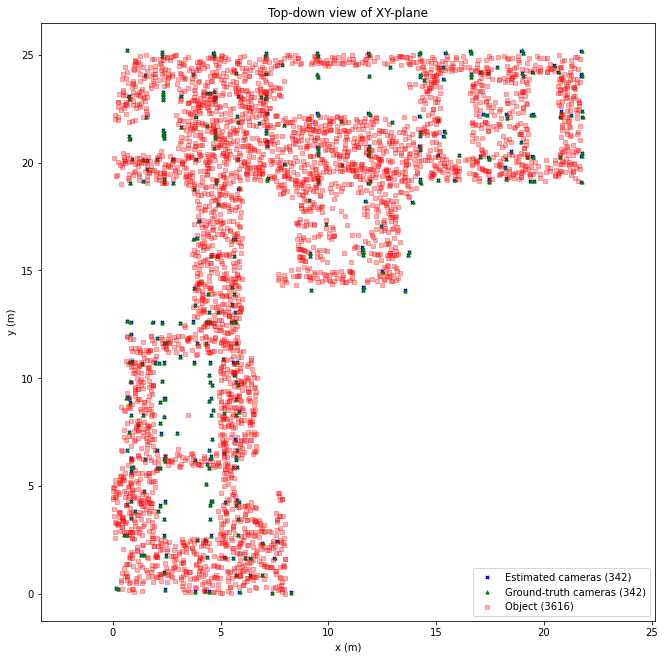

In [37]:
%matplotlib inline
fig = plt.figure(figsize=(11,11))
lgd = []

xy_est = []
for n in valid_cam_ids:
    est = (pose_est[n] @ G).inv().t()
    xy_est.append(est[:2])
xy_est = np.stack(xy_est, axis=0)
plt.scatter(xy_est[:,0], xy_est[:,1], 10, marker='x', c='blue')
lgd.append("Estimated cameras ({})".format(len(valid_cam_ids)))

xy_gt = []
for n in cams.keys():
    gt = cams[n].extrinsics.t()
    xy_gt.append(gt[:2])
xy_gt = np.stack(xy_gt, axis=0)
plt.scatter(xy_gt[:,0],  xy_gt[:,1],  10, marker='^', c='green')
lgd.append("Ground-truth cameras ({})".format(len(cams)))

xy_t = []
for i in range(6):
    with open('./render/aruco_cube_pose_{}.json'.format(i)) as f:
        markers = json.load(f)
    for v in markers.values():
        xy_t.append(v['t'][:2])
xy_t = np.stack(xy_t, axis=0)
plt.scatter(xy_t[:,0],   xy_t[:,1],  10, marker='s', c=[1,0,0,0.3])
lgd.append("Object ({})".format(len(xy_t)))

plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Top-down view of XY-plane')
plt.legend(lgd)

